In [584]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV , RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn import model_selection
from sklearn.metrics import roc_auc_score
import sys
import warnings
pd.set_option('display.max_columns',150)
pd.set_option('display.max_rows',2500)

if not sys.warnoptions:
    warnings.simplefilter("ignore")
    
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.5f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [585]:
data = pd.read_csv(r'./data.csv')

In [586]:
data.head()

,Unnamed: 0,match_event_id,location_x,location_y,power_of_shot,knockout_match,game_season,distance_of_shot,is_goal,area_of_shot,shot_basics,range_of_shot,team_name,date_of_game,home,shot_id_number,lat,type_of_shot,match_id,remaining_min,remaining_sec,power_of_shot.1
0,0,10.0,167,72,1.0,0.0,2000-01,38,NaN,Right Side(R),Mid Range,16-24 ft.,Manchester United,10/31/2000,MANU @ POR,1.0,"45.539131, -122.651648",shot - 30,20000012,10,27,1.0
1,1,12.0,-157,0,1.0,0.0,2000-01,35,0.0,Left Side(L),Mid Range,8-16 ft.,Manchester United,10/31/2000,MANU @ POR,2.0,"45.539131, -122.651648",shot - 45,20000012,10,22,1.0
2,2,35.0,-101,135,1.0,0.0,2000-01,36,1.0,Left Side Center(LC),Mid Range,16-24 ft.,Manchester United,10/31/2000,NaN,3.0,"45.539131, -122.651648",shot - 25,20000012,7,45,1.0
3,3,43.0,138,175,1.0,0.0,2000-01,42,0.0,Right Side Center(RC),Mid Range,16-24 ft.,Manchester United,10/31/2000,MANU @ POR,4.0,"45.539131, -122.651648",shot - 3,20000012,6,52,1.0
4,4,155.0,0,0,2.0,0.0,2000-01,20,1.0,Center(C),Goal Area,Less Than 8 ft.,Manchester United,10/31/2000,MANU @ POR,5.0,"45.539131, -122.651648",shot - 1,20000012,6,19,2.0


In [587]:
data.drop('Unnamed: 0',axis=1,inplace=True)
data.shape

(30697, 21)

In [588]:
data['source']=0
data.ix[data['is_goal'].isnull(),['source']] = 'test'
data['source']=data['source'].replace(0,'train')
data.source.value_counts()

train    24429
test      6268
Name: source, dtype: int64

# filling na values

In [589]:
#   i've manually imputed  na values of distance_of_shot, area_of_shot,
#   shot_basics, range_of_shot, power of shot,type_of_shot using different filters and mean, ramaining min and remaining ses

In [590]:
data['knockout_match'] = data.groupby('match_id')['knockout_match'].transform(lambda x:x.fillna(np.mean(x)))
data['home'] = data.groupby('match_id')['home'].transform(lambda x:x.fillna(x.mode().iat[0]))
data['lat'] = data.groupby('match_id')['lat'].transform(lambda x:x.fillna(x.mode().iat[0]))

In [591]:
data.drop(['power_of_shot.1'],axis=1,inplace=True)

In [592]:
data['date_of_game']=data.groupby('match_id')['date_of_game'].transform(lambda x:x.fillna(x.mode().iat[0]))
data['game_season']=data.groupby('match_id')['game_season'].transform(lambda x:x.fillna(x.mode().iat[0]))

In [593]:
data['area_of_shot'] = data['area_of_shot'].fillna('centre')

In [594]:
data['location_y']=data.groupby(['area_of_shot','shot_basics','range_of_shot','location_x'])['location_y'].transform(lambda x:x.fillna(x.mode().iat[0]))
data['location_x']=data.groupby(['area_of_shot','shot_basics','range_of_shot','location_y'])['location_x'].transform(lambda x:x.fillna(x.mode().iat[0]))

In [595]:
data['power_of_shot'] = data.groupby('range_of_shot')['power_of_shot'].transform(lambda x: x.fillna(x.mode().iat[0]))

In [596]:
data.isnull().sum()

match_event_id      1563
location_x             0
location_y             0
power_of_shot          0
knockout_match         0
game_season            0
distance_of_shot       0
is_goal             6268
area_of_shot           0
shot_basics            0
range_of_shot          0
team_name              0
date_of_game           0
home                   0
shot_id_number      1563
lat                    0
type_of_shot           0
match_id               0
remaining_min          0
remaining_sec          0
source                 0
dtype: int64

# done with imputations

# eda

In [597]:
data.describe(include=['int64'])

,location_x,location_y,distance_of_shot,match_id,remaining_min,remaining_sec
count,30697.000000,30697.000000,30697.000000,3.069700e+04,30697.000000,30697.000000
mean,7.110499,91.107535,33.410626,2.476407e+07,4.885624,28.365085
std,110.124578,87.791361,9.368097,7.755175e+06,3.449897,17.478949
min,-250.000000,-44.000000,20.000000,2.000001e+07,0.000000,0.000000
25%,-68.000000,4.000000,25.000000,2.050008e+07,2.000000,13.000000
50%,0.000000,74.000000,35.000000,2.090035e+07,5.000000,28.000000
75%,95.000000,160.000000,41.000000,2.960047e+07,8.000000,43.000000
max,248.000000,791.000000,99.000000,4.990009e+07,11.000000,59.000000


In [598]:
data.describe(include=['object', 'category'])

,game_season,area_of_shot,shot_basics,range_of_shot,team_name,date_of_game,home,lat,type_of_shot,source
count,30697,30697,30697,30697,30697,30697,30697,30697,30697,30697
unique,20,7,7,5,1,1559,74,38,57,2
top,2005-06,Center(C),Mid Range,Less Than 8 ft.,Manchester United,4/13/2016,MANU @ SAS,"42.982923, -71.446094",shot - 3,train
freq,2319,13546,12468,9394,30697,50,1020,14956,11850,24429


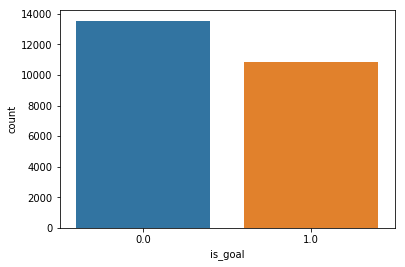

In [599]:
#checking for imbalance and count of goals
sns.countplot(data['is_goal'])

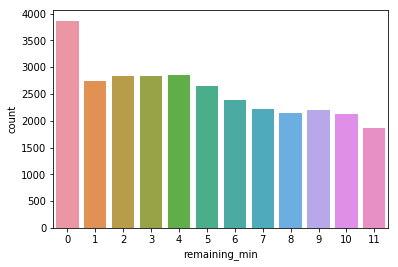

In [600]:
#remaining minute frequency
sns.countplot(data.remaining_min)

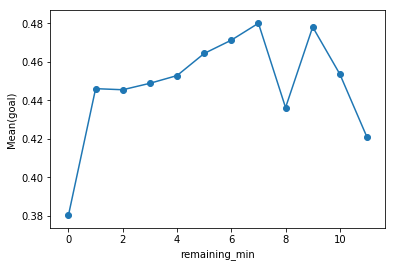

In [601]:
c = data.groupby('remaining_min')['is_goal'].mean()
plt.plot(c.index, c.values)
plt.xlabel('remaining_min')
plt.ylabel('Mean(goal)')
plt.scatter(c.index, c.values)
plt.show()

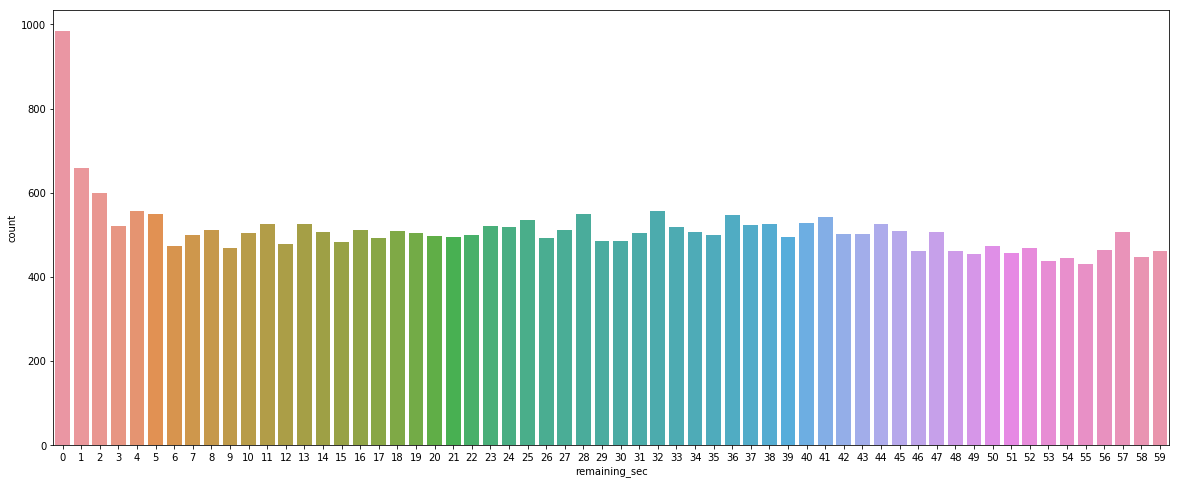

In [602]:
#remining seconds frequency
plt.figure(figsize=(20,8))
sns.countplot(data.remaining_sec)

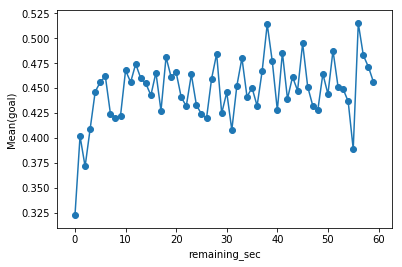

In [603]:
c = data.groupby('remaining_sec')['is_goal'].mean()
plt.plot(c.index, c.values)
plt.xlabel('remaining_sec')
plt.ylabel('Mean(goal)')
plt.scatter(c.index, c.values)
plt.show()

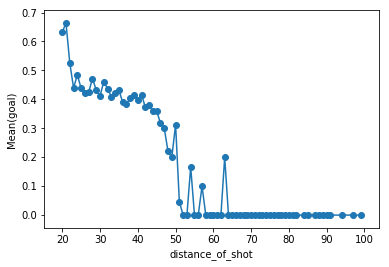

In [604]:
c = data.groupby('distance_of_shot')['is_goal'].mean()
plt.plot(c.index, c.values)
plt.xlabel('distance_of_shot')
plt.ylabel('Mean(goal)')
plt.scatter(c.index, c.values)
plt.show()

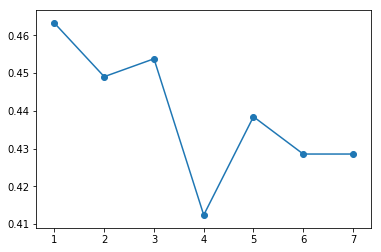

In [605]:
#power of shots
c = data.groupby('power_of_shot')['is_goal'].mean()
plt.plot(c.index, c.values)
plt.scatter(c.index, c.values)
plt.show()

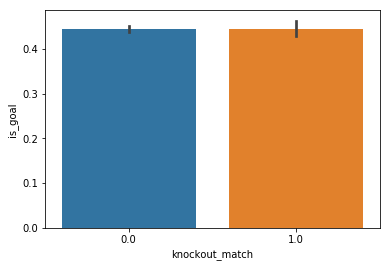

In [606]:
#knockout
sns.barplot('knockout_match', 'is_goal', data=data)


#Not useful

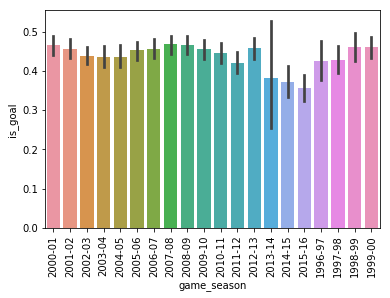

In [607]:
#goal per game
sns.barplot('game_season', 'is_goal', data=data)
plt.xticks(rotation='vertical')
plt.show()

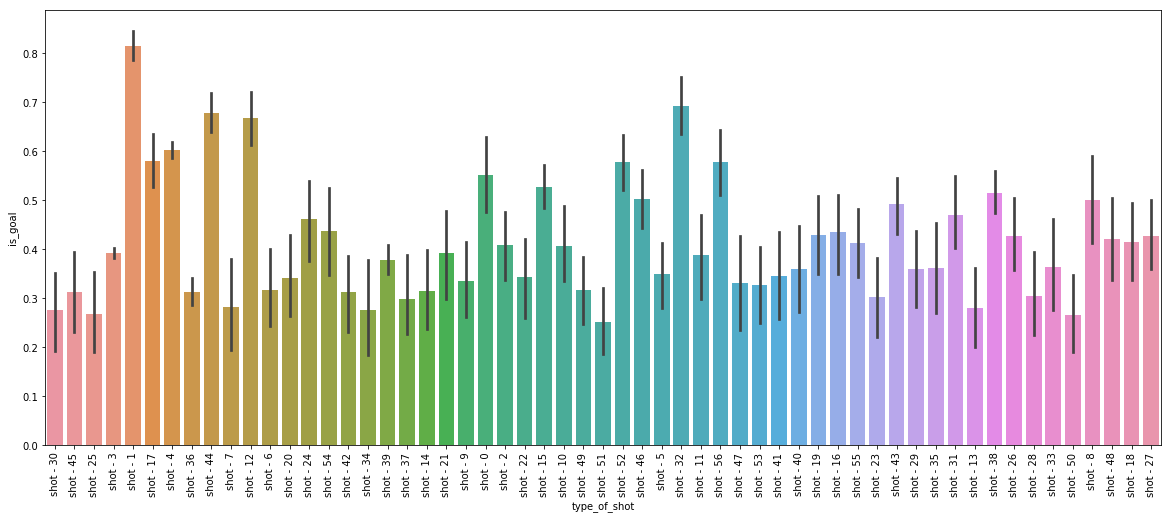

In [608]:
#type of shot vs goal
plt.figure(figsize=(20,8))
sns.barplot(data.type_of_shot, data.is_goal)
plt.xticks(rotation='vertical')
plt.show()

# feature generation

In [609]:
data.head()

,match_event_id,location_x,location_y,power_of_shot,knockout_match,game_season,distance_of_shot,is_goal,area_of_shot,shot_basics,range_of_shot,team_name,date_of_game,home,shot_id_number,lat,type_of_shot,match_id,remaining_min,remaining_sec,source
0,10.0,167,72,1.0,0.0,2000-01,38,NaN,Right Side(R),Mid Range,16-24 ft.,Manchester United,10/31/2000,MANU @ POR,1.0,"45.539131, -122.651648",shot - 30,20000012,10,27,test
1,12.0,-157,0,1.0,0.0,2000-01,35,0.0,Left Side(L),Mid Range,8-16 ft.,Manchester United,10/31/2000,MANU @ POR,2.0,"45.539131, -122.651648",shot - 45,20000012,10,22,train
2,35.0,-101,135,1.0,0.0,2000-01,36,1.0,Left Side Center(LC),Mid Range,16-24 ft.,Manchester United,10/31/2000,MANU @ POR,3.0,"45.539131, -122.651648",shot - 25,20000012,7,45,train
3,43.0,138,175,1.0,0.0,2000-01,42,0.0,Right Side Center(RC),Mid Range,16-24 ft.,Manchester United,10/31/2000,MANU @ POR,4.0,"45.539131, -122.651648",shot - 3,20000012,6,52,train
4,155.0,0,0,2.0,0.0,2000-01,20,1.0,Center(C),Goal Area,Less Than 8 ft.,Manchester United,10/31/2000,MANU @ POR,5.0,"45.539131, -122.651648",shot - 1,20000012,6,19,train


In [610]:
# data['type_of_shot'] = data['type_of_shot'].str.replace("shot", " ")
# data['type_of_shot'] = data['type_of_shot'].str.replace("-", " ")

In [611]:
#coding @ and vs
data['home'] = data.home.apply(lambda x: 0 if (x.split(' ')[1])=='@' else 1)

In [612]:
#converting date_of_game to datetime
data['date_of_game'] = pd.to_datetime(data.date_of_game)

data['game_date_month'] = data.date_of_game.dt.month

data['game_date_quarter'] = data.date_of_game.dt.quarter

In [613]:
#total time
data['time_remaining'] = data.apply(lambda x: x['remaining_min']*60+x['remaining_sec'], axis=1)

In [614]:
#last 3 seconds success rate is lower.
data['timeUnder4'] = data.time_remaining.apply(lambda x: 1 if x<4 else 0)

In [616]:
# data['type_of_shot']= data['type_of_shot'].astype(int)

In [617]:
import math
data['angle'] = data.apply(lambda x: 90 if x['location_y']==0 else math.degrees(math.atan(x['location_x']/abs(x['location_y']))),axis=1)

In [618]:
data['angle_bin'] = pd.cut(data.angle, 8, labels=range(8))
data['angle_bin'] = data.angle_bin.astype(int)

In [619]:
data.type_of_shot.dtypes

dtype('O')

In [620]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(max_features=57, stop_words=['shot','-'])
shot_features = cv.fit_transform(data['type_of_shot']).toarray()
shot_features = pd.DataFrame(shot_features, columns=cv.get_feature_names())
shot_features.head()

,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [621]:
data = pd.concat([data,shot_features], axis=1)

In [622]:
data['distance_bin'] = pd.cut(data.distance_of_shot, bins=10, labels=range(10))

data['distance_bin'] = data.distance_bin.astype(int)

In [623]:
ang_dist = data.groupby(['angle_bin', 'distance_bin'])['is_goal'].agg([np.mean],as_index= False).reset_index()

In [624]:
ang_dist['group'] = range(len(ang_dist))

ang_dist.drop('mean', inplace=True, axis=1)

In [625]:
ang_dist.head()

,angle_bin,distance_bin,group
0,0,0,0
1,0,1,1
2,0,2,2
3,0,3,3
4,1,0,4


In [626]:
data.shape

(30697, 75)

In [627]:
data = data.merge(ang_dist, 'left', ['angle_bin', 'distance_bin'])

In [628]:
data.columns

Index(['match_event_id', 'location_x', 'location_y', 'power_of_shot',
       'knockout_match', 'game_season', 'distance_of_shot', 'is_goal',
       'area_of_shot', 'shot_basics', 'range_of_shot', 'team_name',
       'date_of_game', 'home', 'shot_id_number', 'lat', 'type_of_shot',
       'match_id', 'remaining_min', 'remaining_sec', 'source',
       'game_date_month', 'game_date_quarter', 'time_remaining', 'timeUnder4',
       'angle', 'angle_bin', '10', '11', '12', '13', '14', '15', '16', '17',
       '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29',
       '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41',
       '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53',
       '54', '55', '56', 'distance_bin', 'group'],
      dtype='object')

In [629]:
final = data.drop(['match_event_id','knockout_match', 'game_season','date_of_game','team_name', 'match_id', 'remaining_min',
                   'remaining_sec','shot_id_number', 'lat',],axis=1)

In [630]:
final.drop(['10','11','19','21','26','27','28','33','35','40','41','45','48','55','type_of_shot'],axis=1,inplace=True)

In [633]:
le = LabelEncoder()
col = ['area_of_shot', 'shot_basics', 'range_of_shot']
for col in final:
        final[col] = le.fit_transform(final[col])

In [642]:
train = final[final['source']==1]
test = final[final['source']==0]

In [643]:
train.drop('source',axis=1,inplace=True)
test.drop(['source','is_goal'],axis=1,inplace=True)

In [644]:
train.shape,test.shape

((24429, 50), (6268, 49))

In [645]:
x_train= train.drop('is_goal',axis=1)
y_train = train['is_goal']

In [654]:
x_train, x_test,y_train,y_test = train_test_split(x_train,y_train, test_size = 0.1, random_state =2)

In [655]:
xgb = XGBClassifier(seed=1, learning_rate=0.01, n_estimators=500,silent=False, max_depth=7, subsample=0.6, colsample_bytree=0.6)

In [656]:
xgb_params={
            "gamma":[9,11,10],
            "min_child_weight":[5,6,4]
            }

In [657]:
grid_search=GridSearchCV(xgb,cv=10,param_grid=xgb_params,scoring='roc_auc',verbose=2,n_jobs=-1)

In [658]:
grid_search.fit(x_train,y_train)

Fitting 10 folds for each of 9 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   41.4s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  3.3min finished


GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.6, gamma=0,
       learning_rate=0.01, max_delta_step=0, max_depth=7,
       min_child_weight=1, missing=None, n_estimators=500, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=1, silent=False,
       subsample=0.6, verbosity=1),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'gamma': [9, 11, 10], 'min_child_weight': [5, 6, 4]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=2)

In [659]:
report(grid_search.cv_results_,2)

Model with rank: 1
Mean validation score: 0.644 (std: 0.01430)
Parameters: {'gamma': 9, 'min_child_weight': 4}

Model with rank: 2
Mean validation score: 0.644 (std: 0.01408)
Parameters: {'gamma': 9, 'min_child_weight': 5}



In [660]:
gf= grid_search.best_estimator_

In [661]:
gf.fit(x_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.6, gamma=9,
       learning_rate=0.01, max_delta_step=0, max_depth=7,
       min_child_weight=4, missing=None, n_estimators=500, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=1, silent=False,
       subsample=0.6, verbosity=1)

In [662]:
predicted = gf.predict(x_test)
roc_auc_score(y_test,predicted)

0.6003268306244364

In [663]:
confusion_matrix(y_test, predicted)

array([[1195,  158],
       [ 744,  346]], dtype=int64)

In [667]:
x_train.shape,test.shape

((21986, 49), (6268, 49))

In [668]:
predicted = gf.predict_proba(test)
submission = pd.read_csv(r'./sample_submission.csv')
submission['is_goal'] = predicted
submission.to_csv('submission.csv',index=False)

In [664]:
list(zip(train.columns,  gf.feature_importances_))

[('location_x', 0.013938872),
 ('location_y', 0.0184361),
 ('power_of_shot', 0.014037895),
 ('distance_of_shot', 0.06958388),
 ('is_goal', 0.02627429),
 ('area_of_shot', 0.09832085),
 ('shot_basics', 0.07999937),
 ('range_of_shot', 0.013510021),
 ('home', 0.011872682),
 ('game_date_month', 0.013340564),
 ('game_date_quarter', 0.017809926),
 ('time_remaining', 0.031225987),
 ('timeUnder4', 0.013358255),
 ('angle', 0.024183871),
 ('angle_bin', 0.025075132),
 ('12', 0.009694421),
 ('13', 0.0119178),
 ('14', 0.019637901),
 ('15', 0.013900914),
 ('16', 0.02041488),
 ('17', 0.008443263),
 ('18', 0.010052444),
 ('20', 0.0),
 ('22', 0.009656652),
 ('23', 0.009136305),
 ('24', 0.010141414),
 ('25', 0.013999073),
 ('29', 0.012387889),
 ('30', 0.013255088),
 ('31', 0.02135766),
 ('32', 0.008715653),
 ('34', 0.015934918),
 ('36', 0.0),
 ('37', 0.01785779),
 ('38', 0.06349518),
 ('39', 0.0066825813),
 ('42', 0.01364314),
 ('43', 0.038225073),
 ('44', 0.010715144),
 ('46', 0.0),
 ('47', 0.016774585)

In [669]:
X= train.drop('is_goal',axis=1)
Y = train['is_goal']

In [671]:
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier, GradientBoostingClassifier, VotingClassifier, RandomForestClassifier, AdaBoostClassifier
import xgboost as xgb
from sklearn.feature_selection import VarianceThreshold, RFE, SelectKBest, chi2
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import MinMaxScaler

[-0.64960185 -0.64987683 -0.65614363 -0.65524241 -0.65023143]
Logistic regression: (-0.652) +/- (0.003)
[-1.33494008 -1.38315532 -1.31658134 -1.33793405 -1.367608  ]
Random Forest: (-1.348) +/- (0.024)
[-0.69061584 -0.69018865 -0.69081648 -0.69055186 -0.69072195]
Ada Boost: (-0.691) +/- (0.000)
[-0.64449265 -0.64549735 -0.64761153 -0.6457941  -0.64592863]
Gradient Boosting: (-0.646) +/- (0.001)
[-0.64416411 -0.64534335 -0.64736964 -0.64524802 -0.64596241]
XGBoost: (-0.646) +/- (0.001)


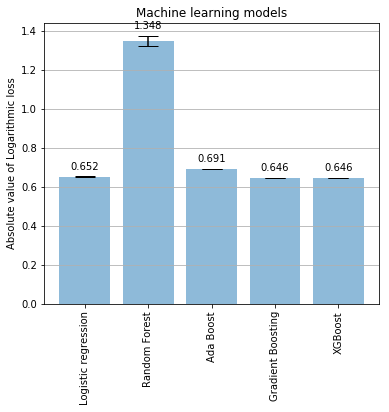

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.6, gamma=0,
       learning_rate=0.01, max_delta_step=0, max_depth=7,
       min_child_weight=1, missing=None, n_estimators=500, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=1, silent=None,
       subsample=0.6, verbosity=1)

In [672]:
seed =50
processors=1
num_folds=5
num_instances=len(X)
scoring='neg_log_loss'


num_trees = 100
num_features = 20
# Prepare some basic models

seed = 50
num_folds = 5
kfold = KFold(n_splits=num_folds, random_state=seed, shuffle = True)

models = []
models.append(('Logistic regression', LogisticRegression()))
models.append(('Random Forest', RandomForestClassifier()))
models.append(('Ada Boost', AdaBoostClassifier()))
models.append(('Gradient Boosting', GradientBoostingClassifier()))
models.append(('XGBoost', xgb.XGBClassifier()))

#models.append(('LDA', LinearDiscriminantAnalysis()))
#models.append(('K-NN', KNeighborsClassifier(n_neighbors=5)))
#models.append(('Decision Tree', DecisionTreeClassifier()))
#models.append(('NB', GaussianNB()))
#models.append(('BAGGED',BaggingClassifier()))
#models.append(('SVC', SVC(probability=True)))

# Evaluate each model in turn
results = []
names = []
stds = []
means =[]
for name, model in models:
    cv_results = cross_val_score(model, X, Y, cv=kfold, scoring='neg_log_loss', n_jobs=1)
    print(cv_results)
    print("{0}: ({1:.3f}) +/- ({2:.3f})".format(name, cv_results.mean(), cv_results.std()))
    results.append(cv_results)
    names.append(name)
    stds.append(cv_results.std())
    means.append(abs(cv_results.mean()))

    
x_pos = np.arange(len(models))
# Build the plot
fig, ax = plt.subplots()
rects1 = ax.bar(x_pos, means, yerr=stds, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('Absolute value of Logarithmic loss')
ax.set_xticks(x_pos)
ax.set_xticklabels(names)
ax.set_title('Machine learning models')
ax.yaxis.grid(True)
plt.subplots_adjust(top=1.1)

def autolabel(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.04*height,
                '%.3f' % height,
                ha='center', va='bottom')

autolabel(rects1)
# Save the figure and show
#plt.tight_layout()
plt.xticks(rotation='vertical')
plt.show()
    
#model = xgb.XGBClassifier(seed=1, learning_rate=0.01, n_estimators=500, max_depth=7, subsample=0.8, colsample_bytree=0.6)

model = xgb.XGBClassifier(seed=1, learning_rate=0.01, n_estimators=500, max_depth=7, subsample=0.6, colsample_bytree=0.6)
model.fit(X, Y)


In [673]:
list(zip(train.columns,  model.feature_importances_))

[('location_x', 0.010097684),
 ('location_y', 0.010722161),
 ('power_of_shot', 0.00812341),
 ('distance_of_shot', 0.036499474),
 ('is_goal', 0.008818914),
 ('area_of_shot', 0.073203325),
 ('shot_basics', 0.025425132),
 ('range_of_shot', 0.008487323),
 ('home', 0.007270283),
 ('game_date_month', 0.006310361),
 ('game_date_quarter', 0.011256818),
 ('time_remaining', 0.029048562),
 ('timeUnder4', 0.0103098275),
 ('angle', 0.0068904352),
 ('angle_bin', 0.040643997),
 ('12', 0.014516927),
 ('13', 0.0119947),
 ('14', 0.026784413),
 ('15', 0.016830113),
 ('16', 0.029676847),
 ('17', 0.010872385),
 ('18', 0.014299958),
 ('20', 0.011109428),
 ('22', 0.014291042),
 ('23', 0.01112173),
 ('24', 0.015857112),
 ('25', 0.013838856),
 ('29', 0.013688852),
 ('30', 0.016821831),
 ('31', 0.032789085),
 ('32', 0.012527015),
 ('34', 0.018233927),
 ('36', 0.011184603),
 ('37', 0.022740565),
 ('38', 0.10347676),
 ('39', 0.012933718),
 ('42', 0.020643255),
 ('43', 0.06301346),
 ('44', 0.013562398),
 ('46', 0.

In [674]:
predicted = model.predict_proba(test)
submission = pd.read_csv(r'./sample_submission.csv')
submission['is_goal'] = predicted
submission.to_csv('submission.csv',index=False)

In [381]:
# #converting distance to bins
# data['distance_bin'] = pd.cut(data.distance_of_shot, bins=10, labels=range(10))
# data['distance_bin']= data['distance_bin'].astype(int)

In [382]:
data.dtypes

match_event_id              float64
location_x                    int64
location_y                    int64
power_of_shot               float64
knockout_match              float64
game_season                  object
distance_of_shot              int64
is_goal                     float64
area_of_shot                 object
shot_basics                  object
range_of_shot                object
team_name                    object
date_of_game         datetime64[ns]
home                          int64
shot_id_number              float64
lat                          object
type_of_shot                  int32
match_id                      int64
remaining_min                 int64
remaining_sec                 int64
source                       object
game_date_month               int64
game_date_quarter             int64
time_remaining                int64
timeUnder4                    int64
dtype: object

In [457]:
predicted = data.drop(['match_event_id','knockout_match', 'game_season','team_name',
       'date_of_game', 'shot_id_number', 'lat',
       'match_id', 'remaining_min', 'remaining_sec'],axis=1)

In [458]:
data.columns

Index(['match_event_id', 'location_x', 'location_y', 'power_of_shot',
       'knockout_match', 'game_season', 'distance_of_shot', 'is_goal',
       'area_of_shot', 'shot_basics', 'range_of_shot', 'team_name',
       'date_of_game', 'home', 'shot_id_number', 'lat', 'type_of_shot',
       'match_id', 'remaining_min', 'remaining_sec', 'source',
       'game_date_month', 'game_date_quarter', 'time_remaining', 'timeUnder4'],
      dtype='object')

In [459]:
data.shape,predicted.shape

((30697, 25), (30697, 15))

In [460]:
predicted.dtypes

location_x             int64
location_y             int64
power_of_shot        float64
distance_of_shot       int64
is_goal              float64
area_of_shot          object
shot_basics           object
range_of_shot         object
home                   int64
type_of_shot           int32
source                object
game_date_month        int64
game_date_quarter      int64
time_remaining         int64
timeUnder4             int64
dtype: object

In [441]:
# cate_features_index = ['shot_basics','range_of_shot','area_of_shot','type_of_shot']

In [461]:
le = LabelEncoder()
predicted['shot_basics'] = le.fit_transform(predicted['shot_basics'])
predicted['range_of_shot'] = le.fit_transform(predicted['range_of_shot'])
predicted['area_of_shot'] = le.fit_transform(predicted['area_of_shot'])

In [462]:
train = predicted[predicted['source']=='train']
test = predicted[predicted['source']=='test']

In [463]:
train.drop('source',axis=1,inplace=True)
test.drop(['source','is_goal'],axis=1,inplace=True)

In [464]:
y_train = train['is_goal']
x_train = train.drop('is_goal',axis=1)

In [465]:
x_train.shape,test.shape

((24429, 13), (6268, 13))

In [468]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV ,RandomizedSearchCV

In [469]:
x_train, x_test,y_train,y_test = train_test_split(x_train,y_train, test_size = 0.2, random_state =2)

In [470]:
x_train.shape,y_train.shape,x_test.shape,y_test.shape

((19543, 13), (19543,), (4886, 13), (4886,))

In [220]:
xgb_params = {  
                "n_estimators":[1000,900,800]
             }

In [221]:
xgb1=XGBClassifier(learning_rate=0.01,subsample=0.8,colsample_bylevel=0.8,colsample_bytree=0.8)

In [222]:
grid_search=GridSearchCV(xgb1,cv=5,param_grid=xgb_params,scoring='roc_auc',verbose=2,n_jobs=-1)

In [223]:
grid_search.fit(x_train,y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:   11.1s remaining:    9.7s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:   12.9s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.8,
       colsample_bynode=1, colsample_bytree=0.8, gamma=0,
       learning_rate=0.01, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=0.8, verbosity=1),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_estimators': [1000, 900, 800]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=2)

In [224]:
report(grid_search.cv_results_,3)

Model with rank: 1
Mean validation score: 0.639 (std: 0.01175)
Parameters: {'n_estimators': 1000}

Model with rank: 2
Mean validation score: 0.639 (std: 0.01177)
Parameters: {'n_estimators': 900}

Model with rank: 3
Mean validation score: 0.638 (std: 0.01188)
Parameters: {'n_estimators': 800}



In [225]:
xgb_params={
            "gamma":[9,11,10],
            "max_depth": [6,7,8],
            "min_child_weight":[5,6,4]
            }

In [226]:
xgb2=XGBClassifier(learning_rate=0.01,n_estimators=1000,subsample=0.8,colsample_bylevel=0.8,colsample_bytree=0.8)

In [227]:
random_search=RandomizedSearchCV(xgb2,param_distributions=xgb_params,n_iter=20,cv=5,scoring='roc_auc',
                                 n_jobs=-1,verbose=2)

In [228]:
random_search.fit(x_train,y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   25.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.6min finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.8,
       colsample_bynode=1, colsample_bytree=0.8, gamma=0,
       learning_rate=0.01, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=0.8, verbosity=1),
          fit_params=None, iid='warn', n_iter=20, n_jobs=-1,
          param_distributions={'gamma': [9, 11, 10], 'max_depth': [6, 7, 8], 'min_child_weight': [5, 6, 4]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring='roc_auc', verbose=2)

In [229]:
report(random_search.cv_results_,3)

Model with rank: 1
Mean validation score: 0.644 (std: 0.01058)
Parameters: {'min_child_weight': 5, 'max_depth': 8, 'gamma': 9}

Model with rank: 2
Mean validation score: 0.644 (std: 0.01068)
Parameters: {'min_child_weight': 6, 'max_depth': 8, 'gamma': 9}

Model with rank: 3
Mean validation score: 0.643 (std: 0.01083)
Parameters: {'min_child_weight': 6, 'max_depth': 7, 'gamma': 9}



In [230]:
xgb_params={
            'max_delta_step':[0,1,3,6,10],
            }

In [231]:
xgb3=XGBClassifier(learning_rate=0.01,n_estimators=1000,min_child_weight=5,gamma=9,max_depth=8,
                  subsample=0.8,colsample_bylevel=0.8,colsample_bytree=0.8)

In [232]:
random_search=RandomizedSearchCV(xgb3,param_distributions=xgb_params,n_iter=5,cv=5,scoring='roc_auc',n_jobs=-1,verbose=10)

In [233]:
random_search.fit(x_train,y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  25 | elapsed:   26.0s remaining:  3.2min
[Parallel(n_jobs=-1)]: Done   6 out of  25 | elapsed:   26.3s remaining:  1.4min
[Parallel(n_jobs=-1)]: Done   9 out of  25 | elapsed:   26.8s remaining:   47.7s
[Parallel(n_jobs=-1)]: Done  12 out of  25 | elapsed:   27.0s remaining:   29.3s
[Parallel(n_jobs=-1)]: Done  15 out of  25 | elapsed:   27.3s remaining:   18.2s
[Parallel(n_jobs=-1)]: Done  18 out of  25 | elapsed:   46.3s remaining:   18.0s
[Parallel(n_jobs=-1)]: Done  21 out of  25 | elapsed:   47.0s remaining:    8.9s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   47.6s finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.8,
       colsample_bynode=1, colsample_bytree=0.8, gamma=9,
       learning_rate=0.01, max_delta_step=0, max_depth=8,
       min_child_weight=5, missing=None, n_estimators=1000, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=0.8, verbosity=1),
          fit_params=None, iid='warn', n_iter=5, n_jobs=-1,
          param_distributions={'max_delta_step': [0, 1, 3, 6, 10]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring='roc_auc', verbose=10)

In [234]:
report(random_search.cv_results_,3)

Model with rank: 1
Mean validation score: 0.644 (std: 0.01058)
Parameters: {'max_delta_step': 0}

Model with rank: 1
Mean validation score: 0.644 (std: 0.01058)
Parameters: {'max_delta_step': 3}

Model with rank: 1
Mean validation score: 0.644 (std: 0.01058)
Parameters: {'max_delta_step': 6}

Model with rank: 1
Mean validation score: 0.644 (std: 0.01058)
Parameters: {'max_delta_step': 10}



In [235]:
xgb_params={
            'subsample':[i/10 for i in range(5,11)],
            'colsample_bytree':[i/10 for i in range(5,11)],
            'colsample_bylevel':[i/10 for i in range(5,11)]
            }

In [236]:
xgb4=XGBClassifier(learning_rate=0.01,n_estimators=1000,min_child_weight=5,gamma=9,max_depth=8,
                        max_delta_step=0
                  )

In [237]:
random_search=RandomizedSearchCV(xgb4,param_distributions=xgb_params,cv=5,n_iter=20,scoring='roc_auc',
                                n_jobs=-1,verbose=20)

In [238]:
random_search.fit(x_train,y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   22.5s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   22.8s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:   22.9s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   22.9s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   23.4s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:   24.0s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:   25.5s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   25.7s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   25.8s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   26.0s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:   26.4s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:   30.6s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:   30.8s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   30.8s
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:  

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=9, learning_rate=0.01,
       max_delta_step=0, max_depth=8, min_child_weight=5, missing=None,
       n_estimators=1000, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1),
          fit_params=None, iid='warn', n_iter=20, n_jobs=-1,
          param_distributions={'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0], 'colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0], 'colsample_bylevel': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring='roc_auc', verbose=20)

In [239]:
report(random_search.cv_results_,3)

Model with rank: 1
Mean validation score: 0.644 (std: 0.01107)
Parameters: {'subsample': 0.8, 'colsample_bytree': 0.6, 'colsample_bylevel': 1.0}

Model with rank: 2
Mean validation score: 0.644 (std: 0.01069)
Parameters: {'subsample': 0.8, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.9}

Model with rank: 3
Mean validation score: 0.644 (std: 0.01002)
Parameters: {'subsample': 0.9, 'colsample_bytree': 0.6, 'colsample_bylevel': 1.0}



In [240]:
gf= random_search.best_estimator_

In [242]:
gf.fit(x_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1.0,
       colsample_bynode=1, colsample_bytree=0.6, gamma=9,
       learning_rate=0.01, max_delta_step=0, max_depth=8,
       min_child_weight=5, missing=None, n_estimators=1000, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=0.8, verbosity=1)

In [245]:
from sklearn.metrics import roc_auc_score,confusion_matrix

predicted = gf.predict(x_train)
roc_auc_score(y_train,predicted)

0.6178262268442303

In [246]:
predicted = gf.predict(x_test)
roc_auc_score(y_test,predicted)

0.6043088413709433

In [247]:
confusion_matrix(y_test, predicted)

array([[2312,  376],
       [1432,  766]], dtype=int64)

In [255]:
confusion_matrix(y_test, predicted)

array([[2263,  425],
       [1374,  824]], dtype=int64)

In [249]:
list(zip(x_train.columns, gf.feature_importances_))

[('location_x', 0.026311016),
 ('location_y', 0.027348783),
 ('power_of_shot', 0.023390962),
 ('distance_of_shot', 0.1255263),
 ('area_of_shot', 0.031095693),
 ('shot_basics', 0.19764562),
 ('range_of_shot', 0.10228321),
 ('home', 0.028160783),
 ('type_of_shot', 0.058948576),
 ('game_date_month', 0.022480302),
 ('game_date_quarter', 0.023026465),
 ('time_remaining', 0.03156301),
 ('timeUnder4', 0.08697146),
 ('distance_bin', 0.14364527),
 ('type_of_shot_bins', 0.07160259)]

In [250]:
predicted = gf.predict_proba(test)
submission = pd.read_csv(r'./sample_submission.csv')
submission['is_goal'] = predicted
submission.to_csv('submission.csv',index=False)

In [471]:
from lightgbm import LGBMClassifier
from sklearn.metrics import confusion_matrix

In [472]:
lgb = LGBMClassifier()

In [473]:
lgb.fit(x_train,y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=-1,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
        random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [474]:
predicted = lgb.predict(x_test)
roc_auc_score(y_test,predicted)

0.6083880705944799

In [475]:
predicted = lgb.predict(x_test)
roc_auc_score(y_test,predicted)

0.6083880705944799

In [476]:
list(zip(x_train.columns , lgb.feature_importances_))

[('location_x', 495),
 ('location_y', 491),
 ('power_of_shot', 155),
 ('distance_of_shot', 249),
 ('area_of_shot', 37),
 ('shot_basics', 26),
 ('range_of_shot', 14),
 ('home', 92),
 ('type_of_shot', 533),
 ('game_date_month', 224),
 ('game_date_quarter', 2),
 ('time_remaining', 678),
 ('timeUnder4', 4)]

In [477]:
confusion_matrix(y_test, predicted)

array([[2263,  425],
       [1374,  824]], dtype=int64)

In [478]:
predicted = lgb.predict_proba(test)
submission = pd.read_csv(r'./sample_submission.csv')
submission['is_goal'] = predicted
submission.to_csv('submission.csv',index=False)